In [48]:
import pylab
import pickle as pkl
import numpy as np
import matplotlib 
import pylab as pb
from pykalman import KalmanFilter
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import GPy
#%matplotlib inline

In [6]:
def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [7]:
allColNames = pkl_loader('allColNames.p')
colHeader, colSlot = allColNames['columnHeaders'], allColNames['columnSlots']
allTrainTS = pkl_loader('allTrainTS.p')
#allTrainTS[some_index] = "2darray(len(colHeader)*len(colSlots))"
allIDs = pkl_loader('allIDs.p')
allTgts = pkl_loader('allTgts.p')
#allIDs[some_index] = "IDOfThisData"
#allTgts[some_index] = "TargetOfThisData"

In [4]:
colHeader,colSlot   #[5]

(['Vital: BP',
  'Vital: Wt for Len Percentile',
  'Vital: Wt for Length ZScore',
  'Vital: PEF',
  'Vital: PainScale',
  'Vital: BMI',
  'Vital: Ht Percentile',
  'Vital: Ht',
  'Vital: HC Percentile',
  'Vital: Temp',
  'Vital: SpO2',
  'Vital: Vision',
  'Vital: Wt Change',
  'Vital: RR',
  'Vital: HR',
  'Vital: PL',
  'Vital: Wt',
  'Vital: BMI Percentile',
  'Vital: Wt Percentile',
  'Vital: Hearing',
  'Vital: Pre-gravid Wt',
  'Vital: HC',
  'Vital: Fundal Ht'],
 ['avg0to1',
  'avg1to3',
  'avg3to5',
  'avg5to7',
  'avg7to10',
  'avg10to13',
  'avg13to16',
  'avg16to19',
  'avg19to24',
  'avg24to27',
  'avg27to33',
  'avg33to42',
  'avg42to54',
  'avg54to66',
  'avg66to78'])

In [8]:
months = [1,3,5,7,10,13,16,19,24,27,33,42,54,66,78]

### Kmeans Grouping

In [9]:
def grouping(data):
    data = [data[i][17] for i in range(len(data))]
    estimator = KMeans(n_clusters=2)#构造聚类器
    estimator.fit(data)#clustering
    label_pred = estimator.labels_
    index_predict1 = np.where(label_pred == 1)[0]
    index_predict0 = np.where(label_pred == 0)[0]
    return index_predict0,index_predict1

### GMM clustering

In [10]:
def grouping_GMM(data):
    data = [data[i][17] for i in range(len(data))]
    gmm = GaussianMixture(n_components = 2).fit(data)
    label_pred = gmm.predict(data)
    index_predict1 = np.where(label_pred == 1)[0]
    index_predict0 = np.where(label_pred == 0)[0]
    return index_predict0,index_predict1

In [11]:
allTrainTS = np.array(allTrainTS)

### Gaussian Process Plots

In [87]:
def kernel_ts(x,y,target,keln = 'rbf',mon = '24',group = 'kmeans',l = '0'):
    pylab
    pb.ion() 
    if keln == 'rbf':
        kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
    elif keln == 'linear':
        kernel = GPy.kern.Linear(input_dim = 1) + GPy.kern.Bias(input_dim = 1) + GPy.kern.White(input_dim = 1)
    elif keln == 'rat':
        kernel = GPy.kern.RatQuad(input_dim=1, variance=1., lengthscale=1.) 
    m_sparse = GPy.models.SparseGPRegression(x, y, kernel, num_inducing=500)
    m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
    _ = m_sparse.optimize()
    _ = m_sparse.plot([0,80],plot_density=True)
    pb.ylim([-10,60])
    pb.plot([66]*target.shape[0],target,'rx')
    pb.savefig(keln+group+mon+l+'.png')

In [76]:
def kernel_plot(group,transdata,target,months,k,grouping = 'kmeans',mon = '24',kel = 'rbf'):
    index0,index1 = group(transdata)
    group_0,group_1 = transdata[index0],transdata[index1]
    target = target.reshape(-1,1)
    group_0_bmi = group_0[:,5,:].reshape(-1,1)
    #print(group_0_bmi.shape)
    x0 = np.array(months[:k]*group_0.shape[0]).reshape(-1,1)
    x0 = x0[(group_0_bmi>0) & (group_0_bmi<50)].reshape(-1,1)
    #print(x0.shape)
    group_0_bmi = group_0_bmi[(group_0_bmi>0) & (group_0_bmi<50)]
    target_0 = target[index0]
    group_1_bmi = group_1[:,5,:].reshape(-1,1)
    x1 = np.array(months[:k]*group_1.shape[0]).reshape(-1,1)
    x1 = x1[(group_1_bmi>0) & (group_1_bmi<50)].reshape(-1,1)
    target_1 = target[index1]
    group_1_bmi = group_1_bmi[(group_1_bmi>0) & (group_1_bmi<50)]
    print('grouping method: {}, data ends at months {}, kernel: group0'.format(grouping,mon))
    kernel_ts(x0,group_0_bmi.reshape(-1,1),target_0.reshape(-1,1),keln = kel,mon = mon,group = grouping,l = '0')
    print('kernel: group1')
    kernel_ts(x1,group_1_bmi.reshape(-1,1),target_1.reshape(-1,1),keln = kel,mon = mon,group = grouping,l = '1')

## kmeans RBF

grouping method: kmeans, data ends at months 24, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 27, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 33, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 42, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 54, kernel: group0
kernel: group1


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


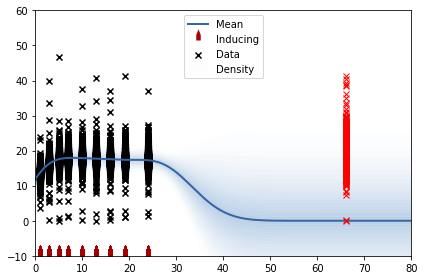

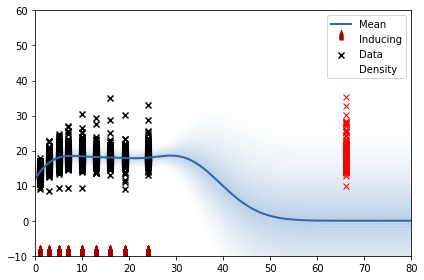

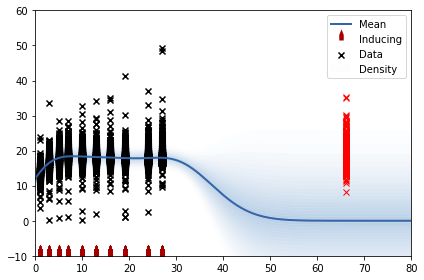

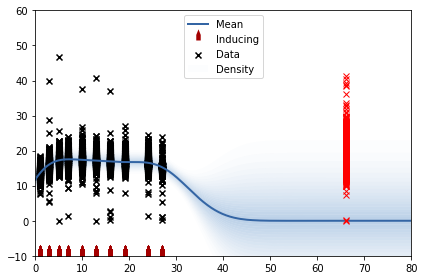

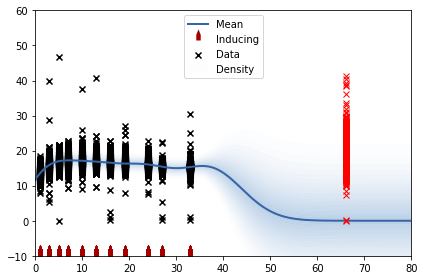

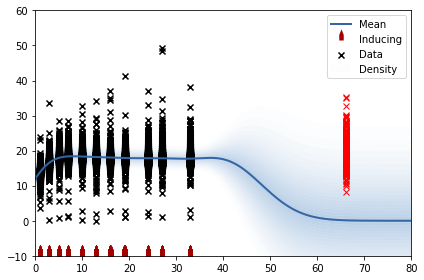

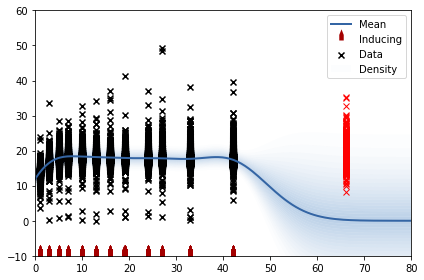

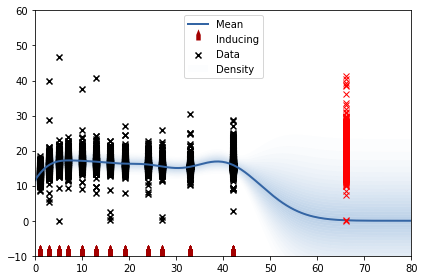

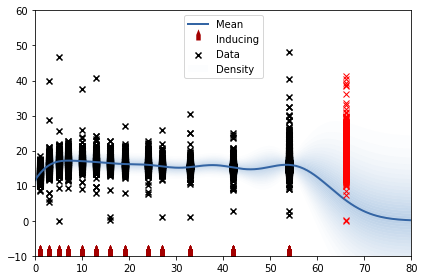

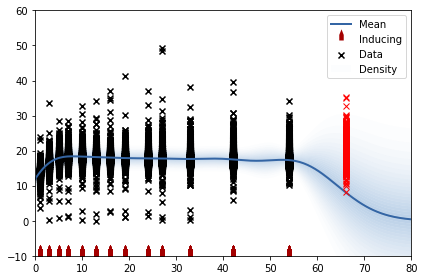

In [77]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping,transdata,allTrainTS[:,5,-2],months,tmp,grouping = 'kmeans',mon = str(months[i]))

## GMM RBF

grouping method: gmm, data ends at months 24, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 27, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 33, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 42, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 54, kernel: group0
kernel: group1


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


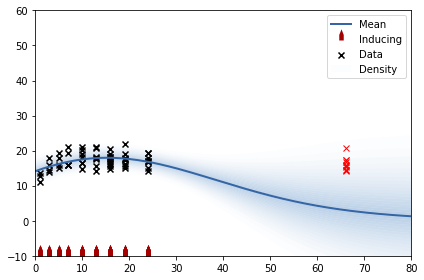

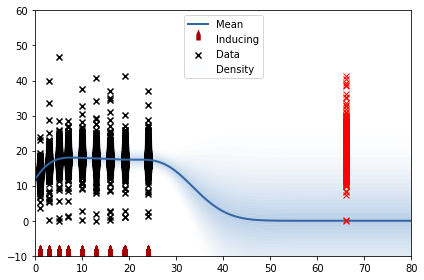

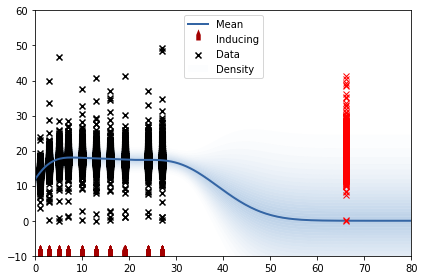

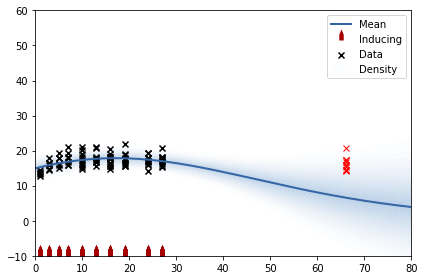

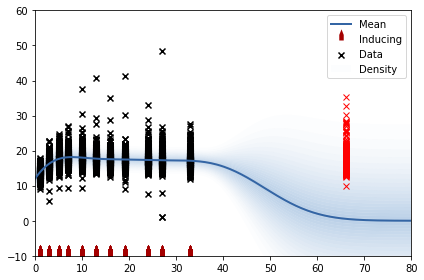

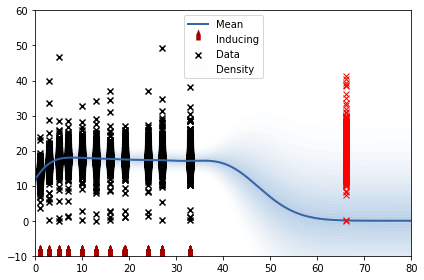

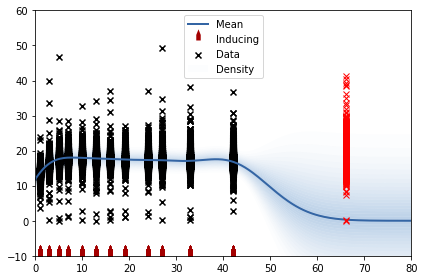

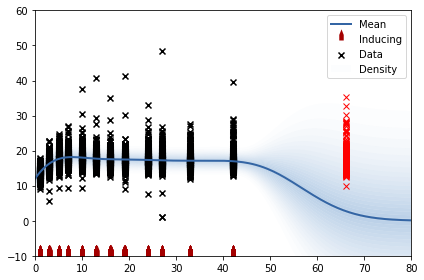

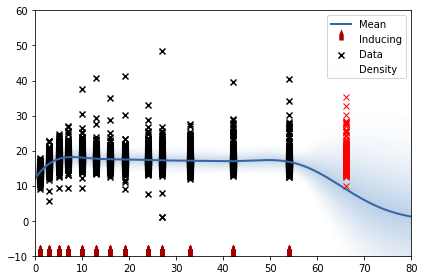

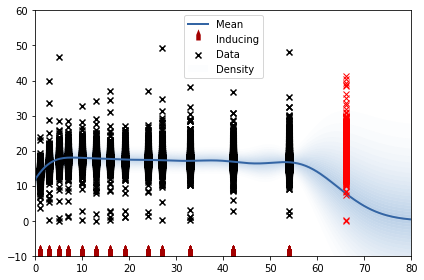

In [78]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping_GMM,transdata,allTrainTS[:,5,-2],months,tmp,grouping = 'gmm',mon = str(months[i]))

## kmeans linear

grouping method: kmeans, data ends at months 24, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 27, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 33, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 42, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 54, kernel: group0
kernel: group1


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


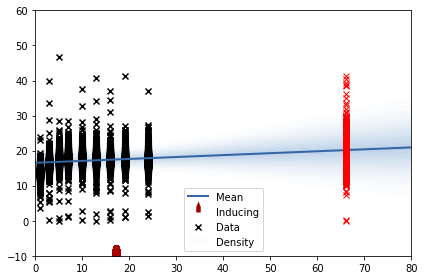

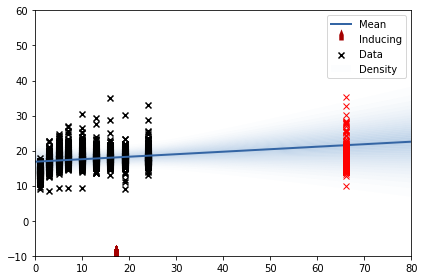

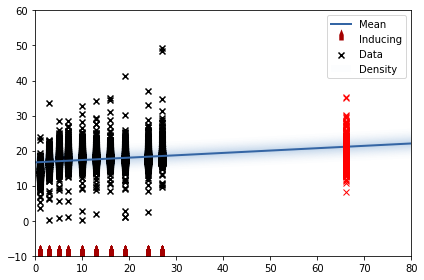

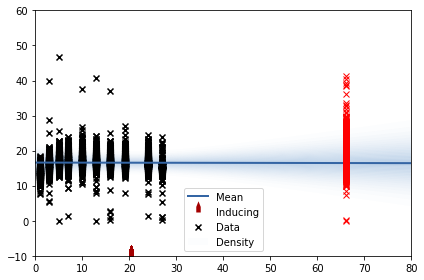

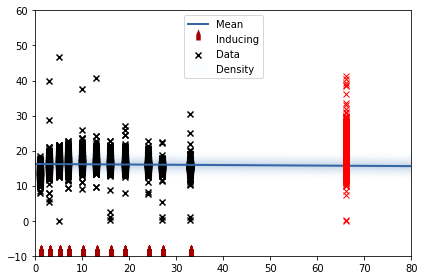

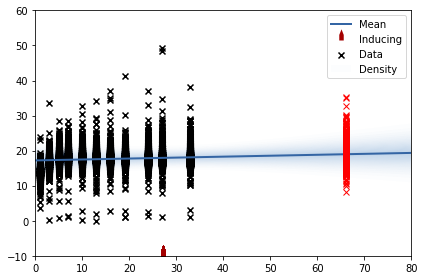

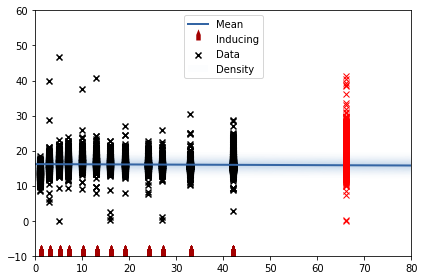

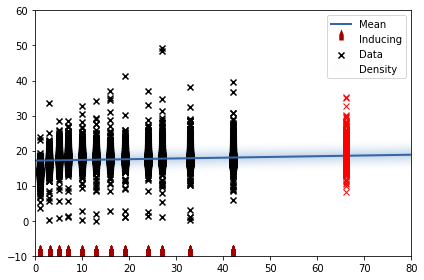

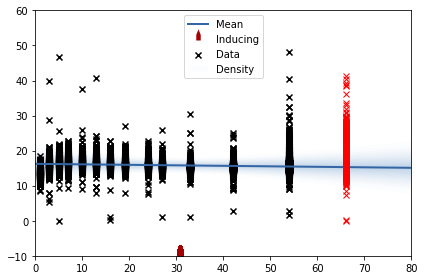

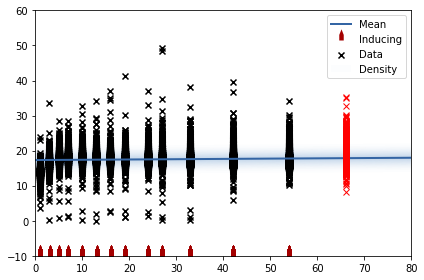

In [88]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping,transdata,allTrainTS[:,5,-2],months,tmp,grouping = 'kmeans',mon = str(months[i]),kel = 'linear')

## GMM linear

grouping method: gmm, data ends at months 24, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 27, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 33, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 42, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 54, kernel: group0
kernel: group1


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


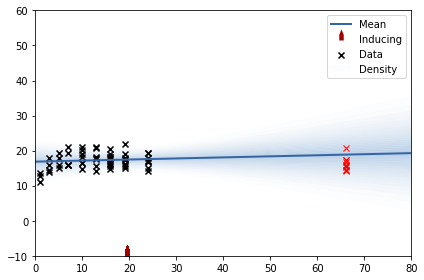

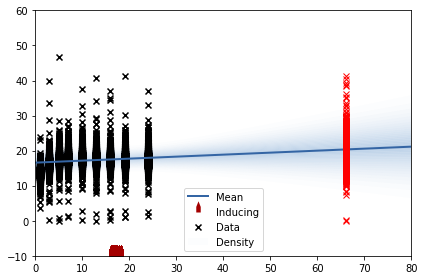

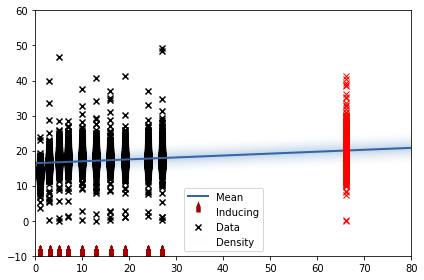

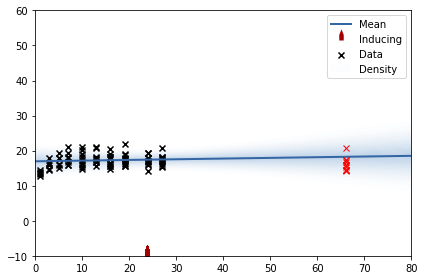

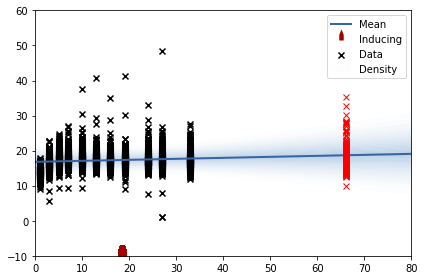

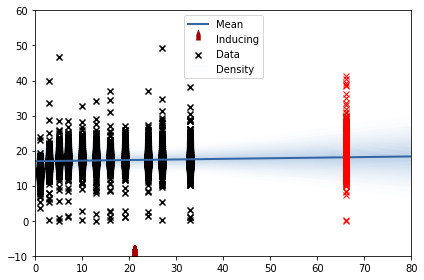

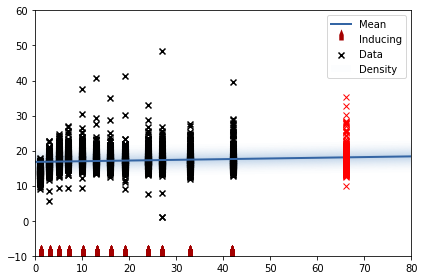

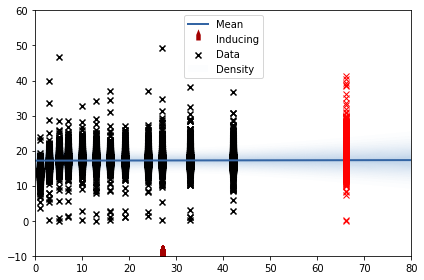

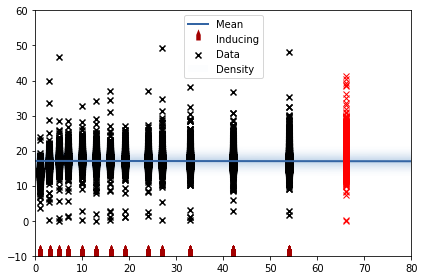

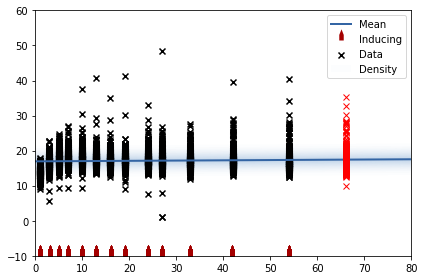

In [89]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping_GMM,transdata, allTrainTS[:,5,-2], months,tmp,grouping = 'gmm',mon = str(months[i]),kel = 'linear')

## kmeans RatQuad

grouping method: kmeans, data ends at months 24, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 27, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 33, kernel: group0


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:678: RuntimeWarning:overflow encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:678: RuntimeWarning:invalid value encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:overflow encountered in multiply
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:overflow encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:invalid value encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy

kernel: group1
grouping method: kmeans, data ends at months 42, kernel: group0
kernel: group1
grouping method: kmeans, data ends at months 54, kernel: group0
kernel: group1


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


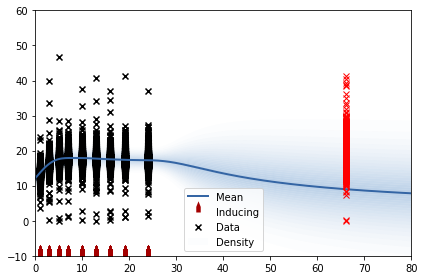

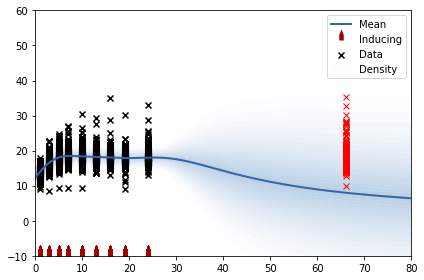

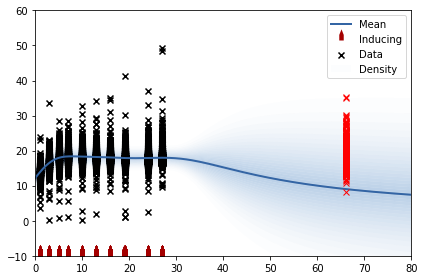

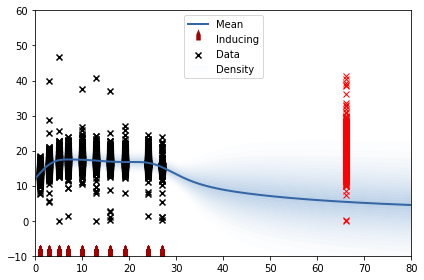

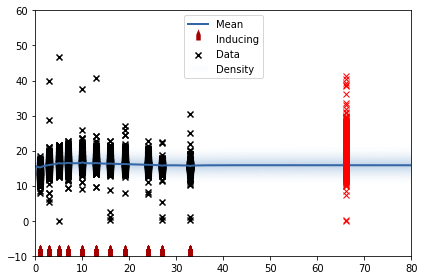

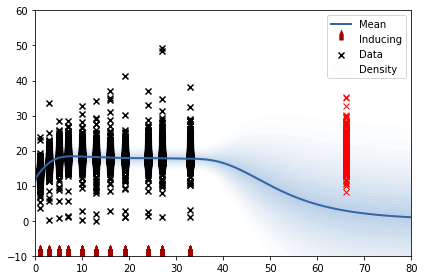

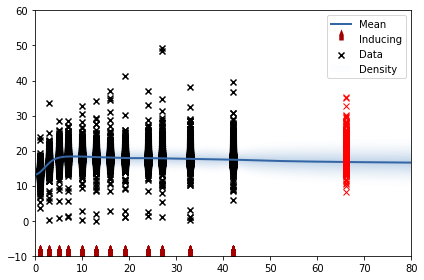

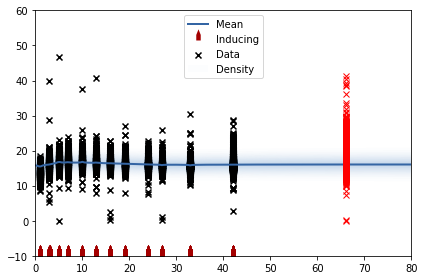

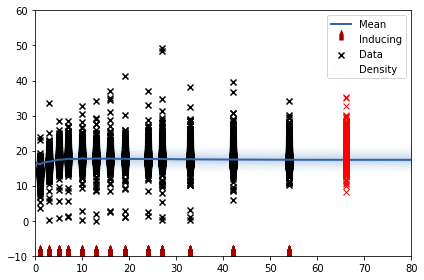

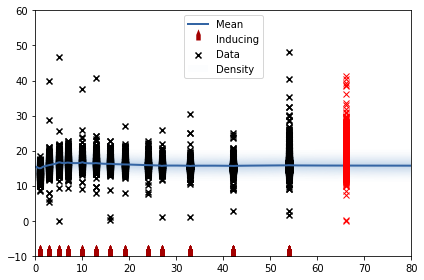

In [90]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping,transdata,allTrainTS[:,5,-2],months,tmp,grouping = 'kmeans',mon = str(months[i]),kel = 'rat')

## GMM RatQuad

grouping method: gmm, data ends at months 24, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 27, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 33, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 42, kernel: group0
kernel: group1
grouping method: gmm, data ends at months 54, kernel: group0


 /anaconda3/lib/python3.6/site-packages/GPy/inference/latent_function_inference/fitc.py:47: RuntimeWarning:invalid value encountered in sqrt


kernel: group1


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:678: RuntimeWarning:overflow encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:678: RuntimeWarning:invalid value encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:overflow encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:invalid value encountered in log1p
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:invalid value encountered in multiply
 /anaconda3/lib/python3.6/site-package

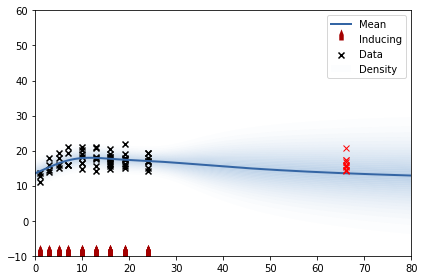

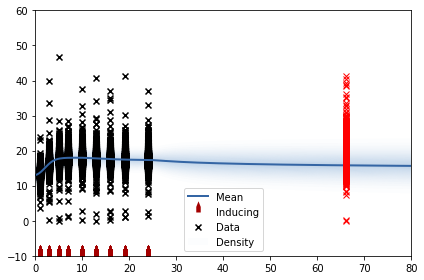

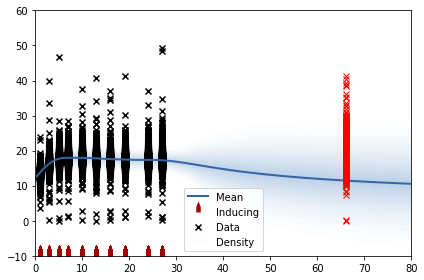

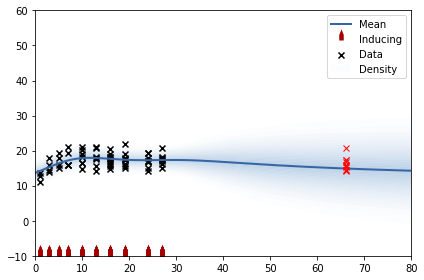

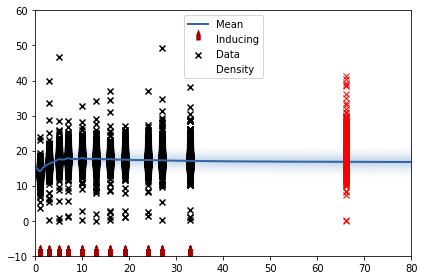

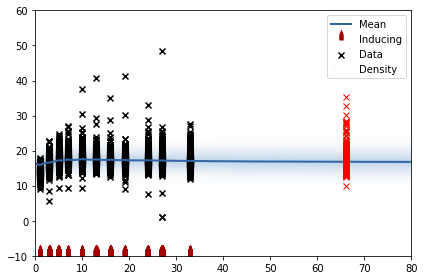

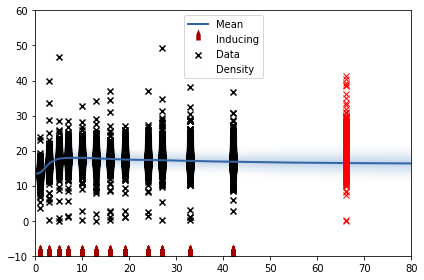

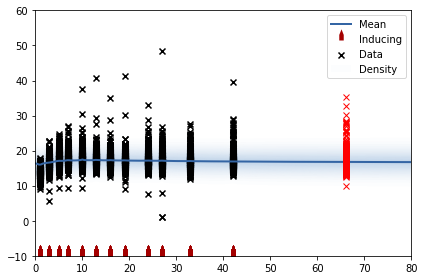

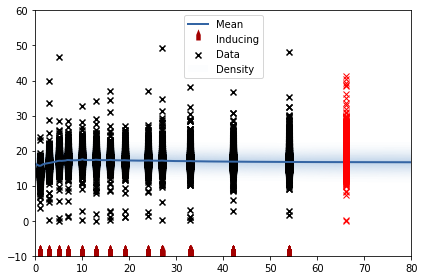

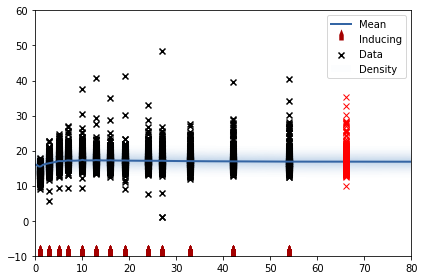

In [91]:
for i in np.arange(8,13):
    tmp = i+1
    transdata = allTrainTS[:,:,0:tmp]
    kernel_plot(grouping_GMM,transdata, allTrainTS[:,5,-2], months,tmp,grouping = 'gmm',mon = str(months[i]),kel = 'rat')